In [20]:
import tensorflow as tf
import keras

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import seaborn as sns

## Data Processing :-

In [22]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [23]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


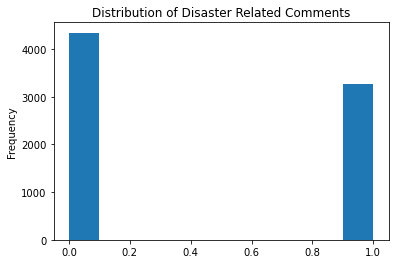

In [24]:
train_df['target'].plot(kind='hist',title="Distribution of Disaster Related Comments")

In [25]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [109]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,SnowballStemmer
lemma = WordNetLemmatizer()
snow = SnowballStemmer(language='english')

In [213]:
def cleaning_comments(df):
    clean_comments = []
        
    for sent in tqdm(df['text']):
        sent = sent.lower()
        clean_sent = sent.translate(str.maketrans("","",string.punctuation))
        clean_words = word_tokenize(clean_sent)
        only_words = [k for k in clean_words if k not in stopwords.words('english')]
        lemma_words = [snow.stem(i) for i in only_words]
        
        clean_comments.append(lemma_words)
        
    return clean_comments
        

In [214]:
train_clean = cleaning_comments(train_df)
test_clean = cleaning_comments(test_df)

100%|█████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:28<00:00, 115.37it/s]


In [205]:
from keras.utils import to_categorical

In [216]:
target = train_df['target'].values
target = to_categorical(target)
num_classes = target.shape[1]

In [217]:
from sklearn.model_selection import train_test_split

In [218]:
x_train,x_test,y_train,y_test = train_test_split(train_clean,target,test_size=0.2,stratify=target)

In [219]:
unique_words = set()
len_max = 0

for sent in tqdm(x_train):
    unique_words.update(sent)
    
    if len(sent) > len_max:
        len_max = len(sent)
        
        
print(len(list(unique_words)))
print(len_max)

100%|██████████████████████████████████████████████████████████████████████████| 6090/6090 [00:00<00:00, 821407.58it/s]

16599
25


In [220]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [221]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(train_clean))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
test_data = tokenizer.texts_to_sequences(test_clean)

x_train = sequence.pad_sequences(x_train,maxlen=len_max,padding='post',truncating='post')
x_test = sequence.pad_sequences(x_test,maxlen=len_max,padding='post',truncating='post')
test_data = sequence.pad_sequences(test_data,maxlen=len_max,padding='post',truncating='post')

## Model Architecture (Sequential) :-

In [222]:
from keras.models import Sequential,Model
from keras.layers import Dense,Embedding,Dropout,LSTM,BatchNormalization,Bidirectional,GlobalMaxPooling1D,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping,ModelCheckpoint
from livelossplot import PlotLossesKeras
from keras.optimizers import Adam, SGD,RMSprop

In [223]:
callback = [ModelCheckpoint("tmp_weights/epochs__{epoch:02d}_acc_{val_accuracy:0.4f}",
                           save_weights_only=True,
                           save_best_only=True,
                           monitor="val_accuracy"),
           #EarlyStopping(patience=6,
            #            monitor='val_accuracy'),
           PlotLossesKeras()]

In [154]:
'''
def create_model():
    model = Sequential()
    
    model.add(Embedding(len(list(unique_words)),100,input_length=len_max,trainable=False))
    model.add(Bidirectional((LSTM(32,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))))
    model.add(Bidirectional(LSTM(16,dropout=0.5,recurrent_dropout=0.5,return_sequences=True)))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes,activation='sigmoid'))
    
    return model

model = create_model()
opt = Adam(lr=0.01)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
'''

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 25, 100)           1669900   
_________________________________________________________________
bidirectional_63 (Bidirectio (None, 25, 64)            34048     
_________________________________________________________________
bidirectional_64 (Bidirectio (None, 25, 32)            10368     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_67 (Dense)             (None, 2)                 66        
Total params: 1,715,438
Trainable params: 45,538
Non-trainable params: 1,669,900
______________________________________

## Functional API Model Approach :-

In [224]:
embedding_layer = Embedding(len(list(unique_words)),
                            300,
                            input_length=len_max,
                            )
input_ = keras.Input(shape=(25,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(16,return_sequences=True))(x)
x = Bidirectional(LSTM(8,return_sequences=True))(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(32,activation='relu')(x)
out = Dense(num_classes,activation='sigmoid')(x)

model = Model(inputs=input_,outputs=out)

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=Adam(lr=0.01))

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 25)                0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 25, 300)           4979700   
_________________________________________________________________
bidirectional_75 (Bidirectio (None, 25, 32)            40576     
_________________________________________________________________
bidirectional_76 (Bidirectio (None, 25, 16)            2624      
_________________________________________________________________
global_average_pooling1d_11  (None, 16)                0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 32)                544 

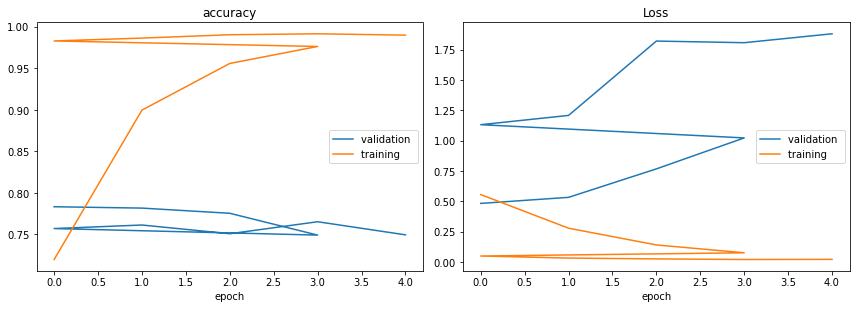

accuracy
	validation       	 (min:    0.749, max:    0.783, cur:    0.750)
	training         	 (min:    0.720, max:    0.992, cur:    0.990)
Loss
	validation       	 (min:    0.483, max:    1.881, cur:    1.881)
	training         	 (min:    0.020, max:    0.555, cur:    0.021)


In [226]:
model.fit(x_train,y_train,
         validation_data = (x_test,y_test),
         epochs = 5,
         batch_size = 128,
         callbacks = callback)

## Calculating Performance Parameters :-

In [227]:
y_pred_on_test = model.predict(x_test)
y_pred_on_test = [np.argmax(i) for i in y_pred_on_test]

In [228]:
from sklearn.metrics import classification_report,f1_score

In [229]:
f1_score(to_categorical(y_pred_on_test),y_test,average='weighted')

0.7497570558844224

In [230]:
print(classification_report(to_categorical(y_pred_on_test),y_test))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       891
           1       0.69      0.72      0.70       632

   micro avg       0.75      0.75      0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523
 samples avg       0.75      0.75      0.75      1523



## Predicting and Saving Output to .csv file :-

In [169]:
y_pred = model.predict(test_data)
y_pred = [np.argmax(i) for i in y_pred]

In [170]:
submission = pd.DataFrame({'id':test_df.id,'target':y_pred})

In [171]:
submission.to_csv("Submission.csv",index=False)

## Saving Model Architecture (Saved Model Format & Json string) :-

In [200]:
model.save("Final_model")

In [201]:
model_json = model.to_json()

with open('model.json','w') as file:
    file.write(model_json)